# Density based clustering with DB-scan

### Importing libraries

In [26]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Scipy
import scipy

# Matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import time
print 'All libraries loaded.'

All libraries loaded.


### Visualizing the dataset

(900, 3)


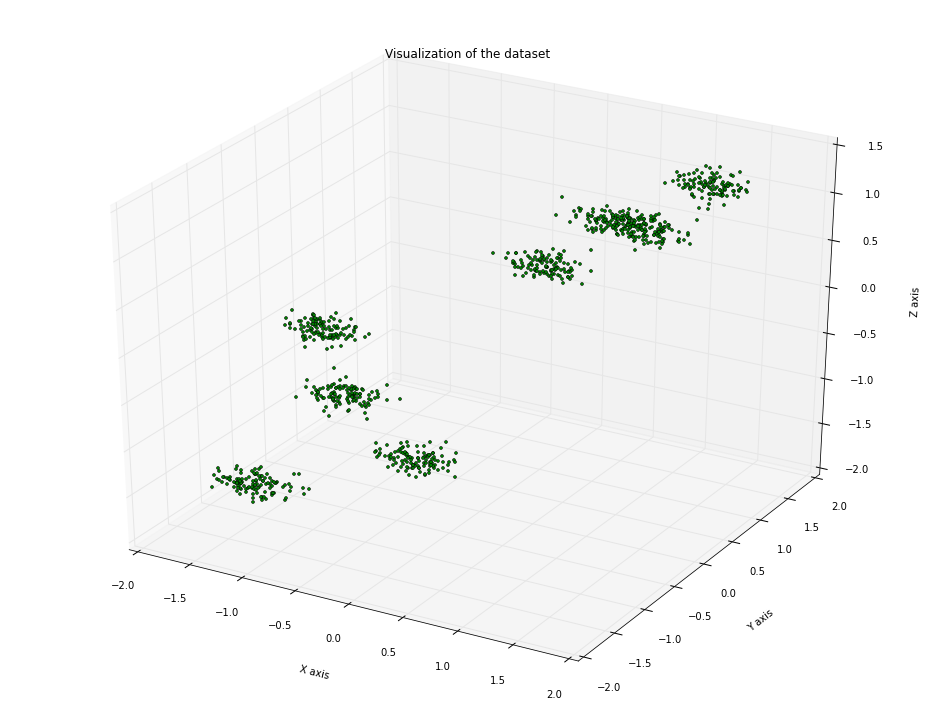

In [117]:
num = 900

centers = [[-2, -8, -6],[0, -4, -6], 
           [-2, -4, 2], [0, -8, 2], 
           [2, 2, 8], [2, -2, 8], 
           [4, 2, 12], [4, -2, 12]
          ]
dataArray, labs = make_blobs(n_samples=num, centers=centers, cluster_std=0.4, random_state=0)
dataArray = StandardScaler().fit_transform(dataArray)
print dataArray.shape

# Plot the dataset

# figure,axis = pyplot.subplots(1,1)
# axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='g', markersize=5)
# axis.set_title('Visualization of the dataset')
# pyplot.show()

from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
fig.set_size_inches(16.5, 12.5)
axis = fig.add_subplot(111, projection='3d')
axis.set_title('Visualization of the dataset')
axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='g', markersize=3)
axis.set_xlabel('X axis')
axis.set_ylabel('Y axis')
axis.set_zlabel('Z axis')

In [118]:
def builtin_dbscan(X, eps=0.3, minPts=50):
    dbscan_inbuilt = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean', algorithm='auto').fit(X)
    dbscan_labels = dbscan_inbuilt.labels_

    core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
    core_samples_mask[dbscan_inbuilt.core_sample_indices_] = True

    # Number of clusters and noise points
    numOfClusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    noisePoints = sum(x == -1 for x in dbscan_labels)
    print 'numOfClusters:',numOfClusters
    print 'noisePoints:',noisePoints
    
    for i in range(0, len(set(dbscan_labels))-1):
        y = sum(x == i for x in dbscan_labels)
        print '# of points with cluster ID',i,'=',y
        
    return dbscan_labels

dbscan_labels = builtin_dbscan(dataArray)

numOfClusters: 8
noisePoints: 1
# of points with cluster ID 0 = 113
# of points with cluster ID 1 = 112
# of points with cluster ID 2 = 112
# of points with cluster ID 3 = 111
# of points with cluster ID 4 = 113
# of points with cluster ID 5 = 113
# of points with cluster ID 6 = 112
# of points with cluster ID 7 = 113


(900, 3)


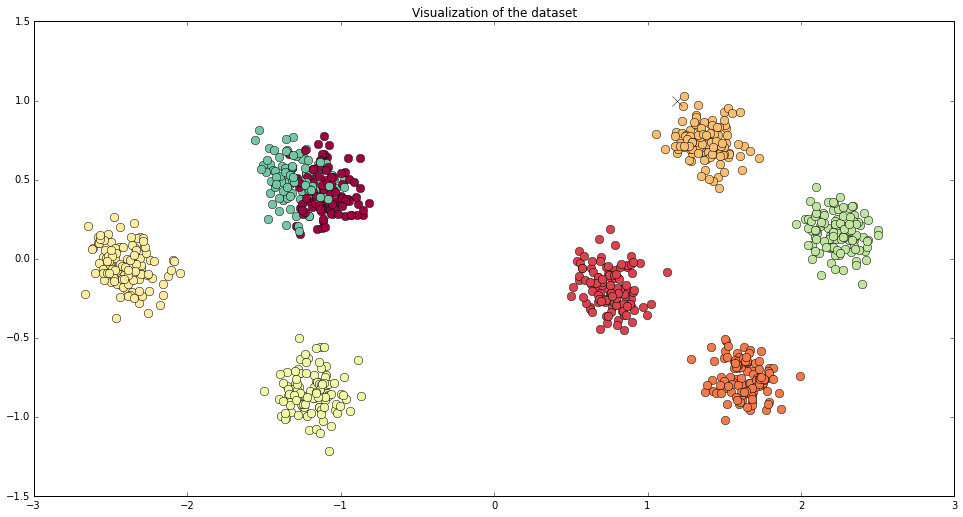

In [120]:
def plot_pca(dataArray, labels):
    
    from matplotlib.mlab import PCA
    from matplotlib import colors
    
    pca_result = PCA(dataArray)
    unique_labels = set(labels)

    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(16.5, 8.5)
    clusterColors = pyplot.cm.Spectral(np.linspace(0, 1, len(unique_labels)+1))

    for i in range(0, dataArray.shape[0]):
        clusterColor = 'k'
        marker = 'o'
        markerSize = 8
        if labels[i] != -1:
            clusterColor = clusterColors[int(labels[i])]
        else:
            # Noise
            marker = 'x'
            markerSize = 10
#         if core_samples_mask[i]:
#             markerSize = 11
        axis.plot(pca_result.Y[i][0], pca_result.Y[i][1], marker, color=clusterColor, markersize=markerSize)
    axis.set_title('Visualization of the dataset')
    pyplot.show()
    
x = np.array(dataArray)
print x.shape
plot_pca(x, dbscan_labels)

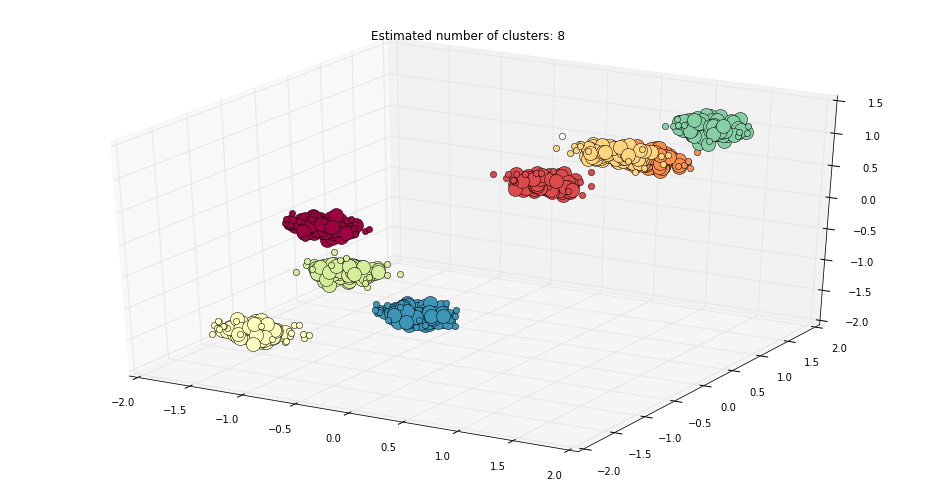

In [30]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
core_samples_mask = np.zeros_like(dbscan_inbuilt.labels_, dtype=bool)
core_samples_mask[dbscan_inbuilt.core_sample_indices_] = True

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

###
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
fig.set_size_inches(16.5, 8.5)
axis = fig.add_subplot(111, projection='3d')
# axis.set_title('Visualization of the dataset')
# axis.plot(dataArray.T[0], dataArray.T[1], dataArray.T[2], 'o', color='g', markersize=3)
####

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'w'

    class_member_mask = (labels == k)

    xy = dataArray[class_member_mask & core_samples_mask]
    axis.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = dataArray[class_member_mask & ~core_samples_mask]
    axis.plot(xy[:, 0], xy[:, 1], xy[:, 2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

axis.set_title('Estimated number of clusters: %d' % numOfClusters)
plt.show()

## Functions for plotting

In [31]:
# Generate points of data for this demo
num_of_points = 10
centers = [[4,4],[8,8]]
dataGrid, labels_true = make_blobs(n_samples=num_of_points, n_features=2, centers=centers, cluster_std=0.6, random_state=0)

def plotPointsAndCircles(dataPoints, circleCentres, neighborhood=[], radius=0.7, markersize=8):
    # Plot the dataset
    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(26.5, 8.5)
    
    # Plot ALL the points first
    axis.plot(dataPoints.T[0], dataPoints.T[1], 'o', color='k', markersize=markersize, alpha=0.65)
    # Plot neighborhood points
    if len(neighborhood) > 0:
        axis.plot(neighborhood.T[0], neighborhood.T[1], 'o', color='lawngreen', markersize=markersize)
    # Plot circle centres
    axis.plot(circleCentres.T[0], circleCentres.T[1], 'o', color='g', markersize=markersize+2)    
    
    axis.set_title('Visualization of the dataset')

    for x in circleCentres:
        circle = plt.Circle(x, radius=radius, color='gray', fill=False)
        plt.gca().add_patch(circle)
    plt.axis('scaled')

    # Define size of the plotted figure
    plt.figure(num=None, figsize=(18.0, 14.0), dpi=580, facecolor='w', edgecolor='k')
    pyplot.show()

## My DB scan implementation functions

In [208]:
# The DB scan function
def dbscan(D, eps, min_pts):
    clust_count = 0
    cluster_map = {}
    noise_pts = []

    for P in D:
        # Considering point P now
        if isVisited(P):
            continue
#         print 'Considering P =', int(P[0]), ', label =', int(P[P.shape[0]-1])
        # --- Don't mark as visited yet. Only if it's a core point.
        
        # Get neighbors of P
        neighbor_pts = regionQuery(P, eps, D)
        neighbors = ""
        for neighbor in neighbor_pts:
            neighbors = neighbors + str(neighbor[0]) + "  "
#         print '\tNeighbors:', neighbors
        
        if neighbor_pts.shape[0] < min_pts:
            # Mark P as noise
#             print '\t', int(P[0]),'is noise.'
            assignLabel(P, D, -1)
            noise_pts.append(P[0])
        else:
#             markAsVisited(P, D)
#             print '\t', int(P[0]),'is a core point. Expanding.'
            # P is a core point.
            # Expand it into a new cluster C
            C, noise_pts = expandCluster(P, neighbor_pts, eps, min_pts, D, noise_pts)
            # print '\nNew cluster =>' , C
            cluster_map[clust_count] = C
            clust_count += 1

    return cluster_map, noise_pts


# Expand cluster
def expandCluster(P, neighbor_pts, eps, min_pts, D, noise_pts):
    # Initialize the cluster C with P
    C = np.empty((0, P.shape[0]))
#     print 'Initially neighbor_pts =', neighbor_pts.shape

    i = 0
    while i < neighbor_pts.shape[0]:
        Q = neighbor_pts[i]
        if not isVisited(Q):
            markAsVisited(Q, D)
            Q_neighbor_pts = regionQuery(Q, eps, D)
            
            if Q_neighbor_pts.shape[0] >= min_pts:
                # Add Q's neighbor points into P's
                for Q_neigh in Q_neighbor_pts:
#                     print 'Comparing Q_neigh[0] =', Q_neigh[0], 'and neighbor_pts[:,0]: ', neighbor_pts[:,0], '====>',(np.extract(neighbor_pts[:,0]==int(Q_neigh[0]), neighbor_pts[:,0]).size > 0)
                    if np.extract(neighbor_pts[:,0]==int(Q_neigh[0]), neighbor_pts[:,0]).size == 0:
                        neighbor_pts = np.concatenate((neighbor_pts, np.array([Q_neigh])), axis=0)
        
        # if Q is not yet member of any cluster
        if D[int(Q[0])-1][D.shape[1]-1] != 1:
            D[int(Q[0])-1][D.shape[1]-1] = 1
            # add Q to this cluster
            C = np.append(C, np.array([Q]), axis=0)
        
        # If Q was previously marked as noise, unmark it.
        if Q[0] in noise_pts:
            noise_pts.remove(Q[0])
        
        i += 1

    print '\tMade cluster of size =', C.shape[0]
    return C, noise_pts


# Returns all points within P's eps-neighborhood (including P)
def regionQuery(P, eps, D):
    neighborhood = []
    lastColumnIndex = P.shape[0]-2
    
    for Q in D:
        # Ignore first 2 columns, and last 2 columns
        distance = scipy.spatial.distance.euclidean(Q[2:Q.shape[0]-2], P[2:P.shape[0]-2])
        if distance <= eps:
            neighborhood.append(Q)
    return np.array(neighborhood)

def isVisited(P):
    return (P[P.shape[0]-2])>0

def assignLabel(P, D, label):
    D[int(P[0])-1][D.shape[1]-1] = label

def markAsVisited(P, D):
    D[int(P[0])-1][D.shape[1]-2] = 1

def print_single_cluster(cluster):
    clust = ""
    for P in cluster:
        clust = clust + str(P[0]) + "  "
    return "[" + clust + "] - Size = " + str(len(cluster))

## Evaluation metric functions
#### These functions are used for evaluating the clustering results. Both internal<br>and external indexing techniques are used for the purpose of evaluation

In [210]:
def calculate_external_indices(clustering_result_map, cho_dataset):
    # Constructing results matrix
    M1 = construct_matrix_predicted(clustering_result_map, cho_dataset.shape[0])
    # Constructing ground truth matrix
    M2 = construct_matrix_ground(make_ground_truth_map(cho_dataset), cho_dataset.shape[0])
    ss = 0.0
    sd = 0.0
    ds = 0.0
    dd = 0.0
    for index in np.ndindex(M1.shape):
        a = M1[index]
        b = M2[index]
        if a == 0 and b == 0:
            dd += 1.0
        elif a == 1 and b == 1:
            ss += 1.0
        elif a == 1 and b == 0:
            sd += 1.0
        elif a == 0 and b == 1:
            ds += 1.0
    jaccard = ss / (ss + sd + ds)
    rand = (ss + dd) / (ss + sd + ds + dd)
    return jaccard, rand


def construct_matrix_ground(cluster_map, matrix_size):
    M = np.zeros((matrix_size+1, matrix_size+1))
    for cluster_id, point_list in cluster_map.iteritems():
        for P1 in point_list:
            for P2 in point_list:
                M[P1][P2] = 1

    M = np.delete(M, 0, 0)
    M = np.delete(M, 0, 1)
    return M


def make_ground_truth_map(D):
    clusterToNodeMap = {}
    for P in D:
        point_id = P[0]
        cluster_id = P[1]
        if cluster_id in clusterToNodeMap:
            existingList = clusterToNodeMap.get(cluster_id)
            existingList.append(int(point_id))
            clusterToNodeMap[cluster_id] = existingList
        else:
            clusterToNodeMap[cluster_id] = [int(point_id)]
    return clusterToNodeMap


def construct_matrix_predicted(cluster_map, matrix_size):
    M = np.zeros((matrix_size+1, matrix_size+1))
    for cluster_id, point_list in cluster_map.iteritems():
        for P1 in point_list:
            for P2 in point_list:
                M[int(P1[0])][int(P2[0])] = 1

    M = np.delete(M, 0, 0)
    M = np.delete(M, 0, 1)
    return M


def calculate_silhouette_coefficient(M, gene_map):
    silhoutte_index = 0;
    row_count = 0
    for i in range(M.shape[0]):
        cluster_id = M[i][-1]
        print "Cluster id: ", cluster_id
        if (cluster_id >= 0):
            row_count += 1
            a = 0
            for j in range(len(gene_map[cluster_id])):
                a = a + scipy.spatial.distance.euclidean(M[i][0:-1], M[gene_map[cluster_id][j] - 1][0:-1])
            a = a / len(gene_map[cluster_id])

            b = 999999999
            for key in gene_map:
                if cluster_id != key:
                    x = 0
                    for value in gene_map[key]:
                        x = x + scipy.spatial.distance.euclidean(M[i][0:-1], M[value - 1][0:-1])
                    b = min(b, x / len(gene_map[key]))
            silhoutte_index = silhoutte_index + (b - a) / max(a, b)

    return "Silhouette: ", silhoutte_index / row_count


# Computing jaccard and rand coefficients
def evaluate(dataset, clustering_result_map):
    jaccard, rand = calculate_external_indices(clustering_result_map, dataset)
    return jaccard, rand

## Load datasets

In [211]:
# Loads the data from the given file into a numpy array
def getDataSetFromFile(filePath, delimiter='\t', datatype=float):
    data_set = np.loadtxt(filePath, delimiter=delimiter, dtype=datatype)

    # Remove the first 2 columns
    # data_set = np.delete(data_set, (0,1), 1)
    
    # Add 2 columns at the end to keep track of visited points, and for labels
    zero_column = np.zeros((data_set.shape[0],1))
    data_set = np.concatenate((data_set, zero_column), axis=1)
    data_set = np.concatenate((data_set, zero_column), axis=1)
    
    # Shuffle the rows up
    # np.random.shuffle(data_set)
    
    return data_set


# Get the datasets
def loadDatasets():
    cho_dataset = getDataSetFromFile('dataset/cho.txt')
    iyer_dataset = getDataSetFromFile('dataset/iyer.txt')
    print 'Datasets loaded.'
    print 'The cho dataset contains', cho_dataset.shape[0], 'record, with', cho_dataset.shape[1]-1, 'features'
    print 'The iyer dataset contains', iyer_dataset.shape[0], 'record, with', iyer_dataset.shape[1]-1, 'features'
    print '2 columns have been added at the end to keep track of visited points, and labels.'
    return cho_dataset, iyer_dataset


# Load datasets
print 'Loading datasets...'
cho_dataset, iyer_dataset = loadDatasets()

Loading datasets...
Datasets loaded.
The cho dataset contains 386 record, with 19 features
The iyer dataset contains 517 record, with 15 features
2 columns have been added at the end to keep track of visited points, and labels.


## Density reachable points

#### Just a demo of density reachability. Given a point P, we have found all neighbors of P <br>that lie within an eps radius of it - also known as density reachable points of P.

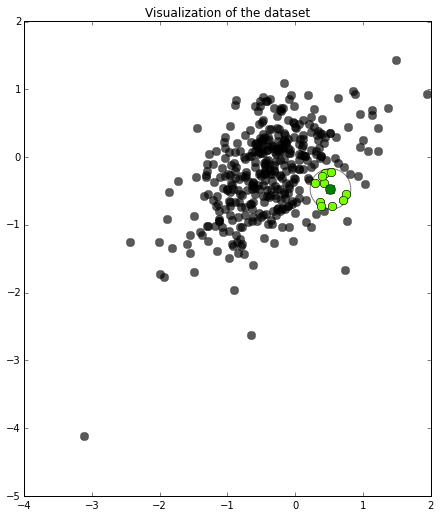

In [212]:
eps = 0.3
cho_dataset_subset = cho_dataset[:, 0:6]

current_point = cho_dataset_subset[354]
neighborhood = regionQuery(P=current_point, eps=eps, D=cho_dataset_subset)
circleCentres = []
circleCentres.append(current_point[2:4])
circleCentres = np.array(circleCentres)

plotPointsAndCircles(cho_dataset_subset[:, 2:4], circleCentres, neighborhood=neighborhood[:,2:4], radius=eps)

In [214]:
# Load datasets
print 'Loading datasets...'
cho_dataset, iyer_dataset = loadDatasets()

# Run DB scan
eps=1.0
min_pts = 5
eps=2.5
min_pts = 20
print "\nStarting DB scan\n----------------"
start_time = time.time()
clustering_result_map, noise_pts = dbscan(cho_dataset, eps=eps, min_pts=min_pts)
print "DB scan completed in", (time.time() - start_time), "seconds."

print '\n# of clusters =>', len(clustering_result_map), '\tnoise points =>', len(noise_pts)

# Evaluate
jaccard, rand = evaluate(cho_dataset, clustering_result_map)
print '\nJaccard =', jaccard
print 'Rand =', rand

Loading datasets...
Datasets loaded.
The cho dataset contains 386 record, with 19 features
The iyer dataset contains 517 record, with 15 features
2 columns have been added at the end to keep track of visited points, and labels.

Starting DB scan
----------------
	Made cluster of size = 381
DB scan completed in 2.31418800354 seconds.

# of clusters => 1 	noise points => 5

Jaccard = 0.228458958034
Rand = 0.243610566727


## Comparison with inbuilt DB-scan function from the scikit library

In [215]:
# Calling built-in DB-scan
builtin_dbscan(iyer_dataset[:, 2:iyer_dataset.shape[1]-2], eps=1.0, minPts = 5)

numOfClusters: 3
noisePoints: 174
# of points with cluster ID 0 = 311
# of points with cluster ID 1 = 5
# of points with cluster ID 2 = 27


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## Visualization of clusters

dataset.shape (386, 16)
ground_labels (386,)


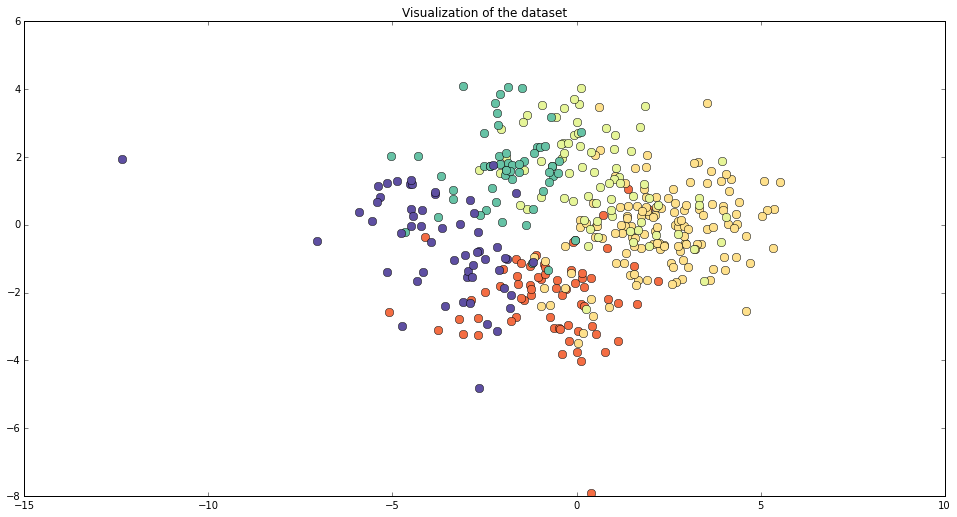

set([1.0, 2.0, 3.0, 4.0, 5.0])


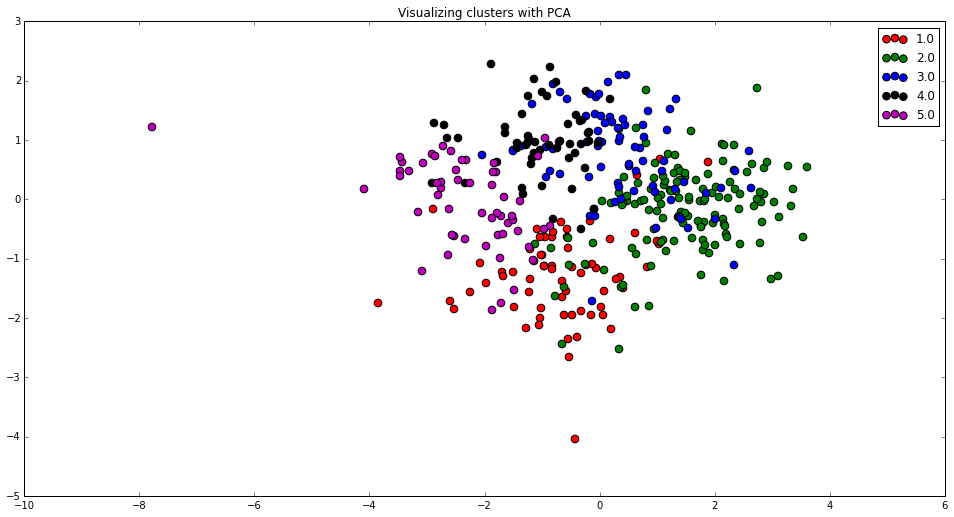

dataset.shape (517, 12)
ground_labels (517,)
set([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, -1.0])


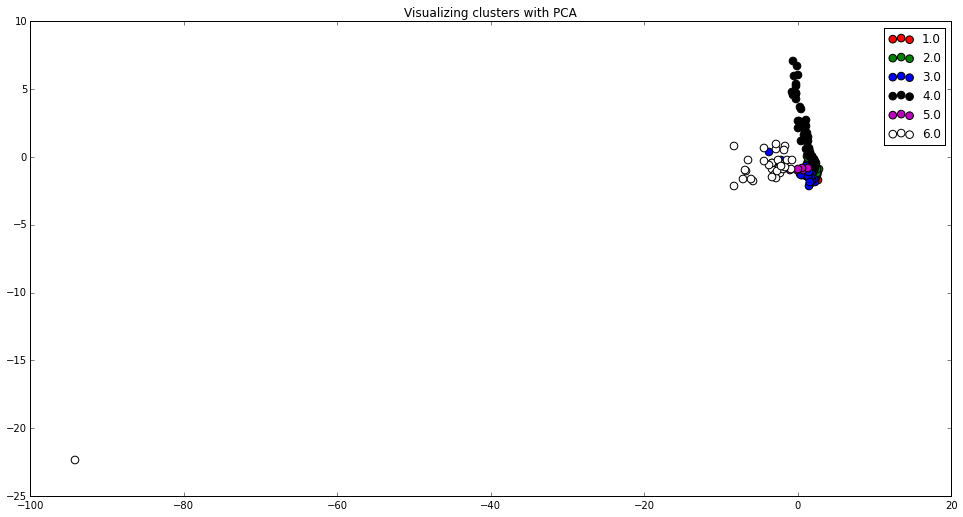

In [216]:
def doPCA(X, labels):
    from sklearn import datasets
    from sklearn.decomposition import PCA

    unique_labels = set(labels)
    print unique_labels

    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    plt.figure()
    figure,axis = pyplot.subplots(1,1)
    figure.set_size_inches(16.5, 8.5)
    for c, i, unique_labels in zip("rgbkmw", unique_labels, unique_labels):
        plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], c=c, label=unique_labels, s=58)
    plt.legend()
    plt.title('Visualizing clusters with PCA')

    plt.show()
    
dataset = cho_dataset[:, 2:cho_dataset.shape[1]-2]
ground_labels = cho_dataset[:,1]
print 'dataset.shape', dataset.shape
print 'ground_labels', ground_labels.shape
plot_pca(dataset, ground_labels)
doPCA(dataset, ground_labels)

dataset = iyer_dataset[:, 2:iyer_dataset.shape[1]-2]
ground_labels = iyer_dataset[:,1]
print 'dataset.shape', dataset.shape
print 'ground_labels', ground_labels.shape
# plot_pca(dataset, ground_labels)
doPCA(dataset, ground_labels)